In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

In [43]:
# 필요 라이브러리
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils         import class_weight
from sklearn.metrics       import precision_score,recall_score, f1_score
from tensorflow.keras       import Input, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils   import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

In [44]:
# 파라미터 튜닝
my_optimizer = Adam(learning_rate=0.01)
my_patience = 100
my_epochs = 100000
my_batch_size = 1024

# 전통 DNN 방식 모델

# 데이터 & 전처리

In [67]:
# 데이터 로드
df = pd.read_csv("model_1/total_data.csv", parse_dates=["일시"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27375 entries, 0 to 27374
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   연           27375 non-null  int64         
 1   행정구         27375 non-null  object        
 2   월           27375 non-null  int64         
 3   일           27375 non-null  int64         
 4   요일          27375 non-null  int64         
 5   평일1주말0      27375 non-null  int64         
 6   총생활인구수      27375 non-null  float64       
 7   남자어린이       27375 non-null  float64       
 8   10대남자       27375 non-null  float64       
 9   20대남자       27375 non-null  float64       
 10  30대남자       27375 non-null  float64       
 11  40대남자       27375 non-null  float64       
 12  50대남자       27375 non-null  float64       
 13  60대남자       27375 non-null  float64       
 14  70대_이상_남자   27375 non-null  float64       
 15  여자어린이       27375 non-null  float64       
 16  10대여자       27375 non-

In [46]:
# 시계열 특징 추가
df["month"]      = df["일시"].dt.month
df["weekday"]    = df["일시"].dt.weekday
df["is_weekend"] = (df["weekday"]>=5).astype(int)

In [47]:
# 행정구 라벨인코딩
le_gu   = LabelEncoder()
df["gu_le"] = le_gu.fit_transform(df["행정구"])

In [48]:
# 총 대여량 => 5개 분류 (대여 흐름 파악 용도)

bins   = [0, 1500, 3000, 4500, 6000,7500,9000, np.inf]
labels = ["0–1499", "1500–2999","3000–4499", "4500–5999", "6000–7499", "7500-8999","9000+"]

df["y_bin"] = pd.cut(df["총대여량"], bins=bins, labels=labels, right=False)
df.dropna(subset=["y_bin"], inplace=True)

# 라벨 인코딩
le_y = LabelEncoder()
df["y_label"] = le_y.fit_transform(df["y_bin"])
n_classes = df["y_label"].nunique()

In [49]:
# 데이터 구분(연도에 따라, 시계열 특징활용을 위함)
train_df = df[df["일시"].dt.year != 2024]
valid_df  = df[df["일시"].dt.year == 2024]

In [50]:
# 1. 사용할 feature 선택 : 행정구별, 기후, 월, 요일별, 주말구분, 총 생활인구수, 자전거 전용도로km수
FEATURE_WEATHER = ["평균기온(°C)","일강수량(mm)","평균 풍속(m/s)","평균 상대습도(%)"]
FEATURES = ["gu_le","month","weekday","is_weekend",'총생활인구수','자전거전용도로km'] + FEATURE_WEATHER

In [11]:
# # 2. 사용할 feature 선택 : 행정구별, 기후, 월, 요일별, 주말구분
# FEATURE_WEATHER = ["평균기온(°C)","일강수량(mm)","평균 풍속(m/s)","평균 상대습도(%)"]
# FEATURES = ["gu_le","month","weekday","is_weekend"] + FEATURE_WEATHER

In [51]:
# 독립변수 스케일 조정
X_tr = train_df[FEATURES].values
X_va = valid_df[FEATURES].values

scaler = StandardScaler().fit(X_tr)

X_tr = scaler.transform(X_tr)
X_va = scaler.transform(X_va)

In [52]:
# 종속변수 스케일 조정
y_tr = to_categorical(train_df["y_label"], num_classes=n_classes)
y_va = to_categorical(valid_df["y_label"], num_classes=n_classes)

In [53]:
# 클래스 가중치 계산 (불균형 완화)
cw = class_weight.compute_class_weight(
    "balanced", classes=np.unique(train_df["y_label"]), y=train_df["y_label"]
)
class_weights = dict(enumerate(cw))

# 모델 설계

In [54]:
inp = Input(shape=(X_tr.shape[1],), name="dnn_in")

x   = Dense(1024, activation="relu", kernel_regularizer=l2(1e-4))(inp)
x   = BatchNormalization()(x)
x   = Dropout(0.49)(x)

# x   = Dense(1024, activation="relu", kernel_regularizer=l2(1e-4))(x)
# x   = BatchNormalization()(x)
# x   = Dropout(0.2)(x)

x   = Dense(512, activation="relu", kernel_regularizer=l2(1e-4))(x)
x   = BatchNormalization()(x)
x   = Dropout(0.49)(x)

x   = Dense(128, activation="relu", kernel_regularizer=l2(1e-4))(x)
x   = BatchNormalization()(x)
x   = Dropout(0.49)(x)

out = Dense(n_classes, activation="softmax")(x)

model = Model(inp, out)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dnn_in (InputLayer)         [(None, 10)]              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              11264     
                                                                 
 batch_normalization_3 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                           

# 모델 학습과정 설정

In [55]:
model.compile(
    optimizer=my_optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"])

# 모델 학습하기

In [56]:
%%time
# 콜백함수
earlystop  = EarlyStopping(monitor="val_accuracy", patience=my_patience, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_1_checkpoint/DNN-{epoch:03d}-val{val_accuracy:.4f}.h5',monitor='val_accuracy',save_best_only=True)
# 4) 학습
hist = model.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=my_epochs, batch_size=my_batch_size,
    class_weight=class_weights,
    callbacks=[earlystop, checkpoint],
    verbose=2
)

Epoch 1/100000
18/18 - 1s - loss: 1.7975 - accuracy: 0.3905 - val_loss: 2.3633 - val_accuracy: 0.3253 - 1s/epoch - 57ms/step
Epoch 2/100000
18/18 - 0s - loss: 1.4689 - accuracy: 0.4796 - val_loss: 1.6802 - val_accuracy: 0.4152 - 130ms/epoch - 7ms/step
Epoch 3/100000
18/18 - 0s - loss: 1.4136 - accuracy: 0.5004 - val_loss: 1.5642 - val_accuracy: 0.4231 - 138ms/epoch - 8ms/step
Epoch 4/100000
18/18 - 0s - loss: 1.3307 - accuracy: 0.5170 - val_loss: 1.6952 - val_accuracy: 0.3931 - 94ms/epoch - 5ms/step
Epoch 5/100000
18/18 - 0s - loss: 1.2570 - accuracy: 0.5390 - val_loss: 1.8554 - val_accuracy: 0.3084 - 110ms/epoch - 6ms/step
Epoch 6/100000
18/18 - 0s - loss: 1.1926 - accuracy: 0.5568 - val_loss: 1.8848 - val_accuracy: 0.3031 - 103ms/epoch - 6ms/step
Epoch 7/100000
18/18 - 0s - loss: 1.1602 - accuracy: 0.5675 - val_loss: 1.8667 - val_accuracy: 0.3032 - 98ms/epoch - 5ms/step
Epoch 8/100000
18/18 - 0s - loss: 1.1228 - accuracy: 0.5748 - val_loss: 1.8046 - val_accuracy: 0.3304 - 97ms/epoch 

Epoch 66/100000
18/18 - 0s - loss: 0.9383 - accuracy: 0.6807 - val_loss: 1.0642 - val_accuracy: 0.6105 - 110ms/epoch - 6ms/step
Epoch 67/100000
18/18 - 0s - loss: 0.9444 - accuracy: 0.6806 - val_loss: 1.0841 - val_accuracy: 0.6075 - 104ms/epoch - 6ms/step
Epoch 68/100000
18/18 - 0s - loss: 0.9445 - accuracy: 0.6790 - val_loss: 1.0448 - val_accuracy: 0.6248 - 99ms/epoch - 5ms/step
Epoch 69/100000
18/18 - 0s - loss: 0.9364 - accuracy: 0.6836 - val_loss: 1.0236 - val_accuracy: 0.6325 - 103ms/epoch - 6ms/step
Epoch 70/100000
18/18 - 0s - loss: 0.9476 - accuracy: 0.6774 - val_loss: 1.0712 - val_accuracy: 0.6102 - 95ms/epoch - 5ms/step
Epoch 71/100000
18/18 - 0s - loss: 0.9385 - accuracy: 0.6823 - val_loss: 1.0199 - val_accuracy: 0.6324 - 111ms/epoch - 6ms/step
Epoch 72/100000
18/18 - 0s - loss: 0.9396 - accuracy: 0.6814 - val_loss: 1.0482 - val_accuracy: 0.6205 - 104ms/epoch - 6ms/step
Epoch 73/100000
18/18 - 0s - loss: 0.9449 - accuracy: 0.6782 - val_loss: 1.0257 - val_accuracy: 0.6334 - 1

Epoch 130/100000
18/18 - 0s - loss: 0.9272 - accuracy: 0.6890 - val_loss: 1.0883 - val_accuracy: 0.6035 - 107ms/epoch - 6ms/step
Epoch 131/100000
18/18 - 0s - loss: 0.9237 - accuracy: 0.6943 - val_loss: 1.0383 - val_accuracy: 0.6357 - 92ms/epoch - 5ms/step
Epoch 132/100000
18/18 - 0s - loss: 0.9379 - accuracy: 0.6842 - val_loss: 1.0191 - val_accuracy: 0.6344 - 122ms/epoch - 7ms/step
Epoch 133/100000
18/18 - 0s - loss: 0.9297 - accuracy: 0.6855 - val_loss: 1.0589 - val_accuracy: 0.6282 - 117ms/epoch - 6ms/step
Epoch 134/100000
18/18 - 0s - loss: 0.9282 - accuracy: 0.6879 - val_loss: 1.0994 - val_accuracy: 0.6038 - 111ms/epoch - 6ms/step
Epoch 135/100000
18/18 - 0s - loss: 0.9379 - accuracy: 0.6861 - val_loss: 1.0660 - val_accuracy: 0.6252 - 124ms/epoch - 7ms/step
Epoch 136/100000
18/18 - 0s - loss: 0.9300 - accuracy: 0.6838 - val_loss: 1.1002 - val_accuracy: 0.6001 - 120ms/epoch - 7ms/step
Epoch 137/100000
18/18 - 0s - loss: 0.9284 - accuracy: 0.6877 - val_loss: 1.0989 - val_accuracy: 0

Epoch 194/100000
18/18 - 0s - loss: 0.9114 - accuracy: 0.6909 - val_loss: 1.0836 - val_accuracy: 0.6110 - 101ms/epoch - 6ms/step
Epoch 195/100000
18/18 - 0s - loss: 0.9216 - accuracy: 0.6915 - val_loss: 1.0857 - val_accuracy: 0.6108 - 122ms/epoch - 7ms/step
Epoch 196/100000
18/18 - 0s - loss: 0.9188 - accuracy: 0.6850 - val_loss: 1.0678 - val_accuracy: 0.6091 - 107ms/epoch - 6ms/step
Epoch 197/100000
18/18 - 0s - loss: 0.9158 - accuracy: 0.6893 - val_loss: 1.0335 - val_accuracy: 0.6363 - 96ms/epoch - 5ms/step
Epoch 198/100000
18/18 - 0s - loss: 0.9216 - accuracy: 0.6868 - val_loss: 1.0127 - val_accuracy: 0.6379 - 115ms/epoch - 6ms/step
Epoch 199/100000
18/18 - 0s - loss: 0.9211 - accuracy: 0.6812 - val_loss: 1.0533 - val_accuracy: 0.6213 - 102ms/epoch - 6ms/step
Epoch 200/100000
18/18 - 0s - loss: 0.9156 - accuracy: 0.6873 - val_loss: 1.0313 - val_accuracy: 0.6431 - 103ms/epoch - 6ms/step
Epoch 201/100000
18/18 - 0s - loss: 0.9252 - accuracy: 0.6882 - val_loss: 1.0798 - val_accuracy: 0

# 모델 학습과정 살펴보기

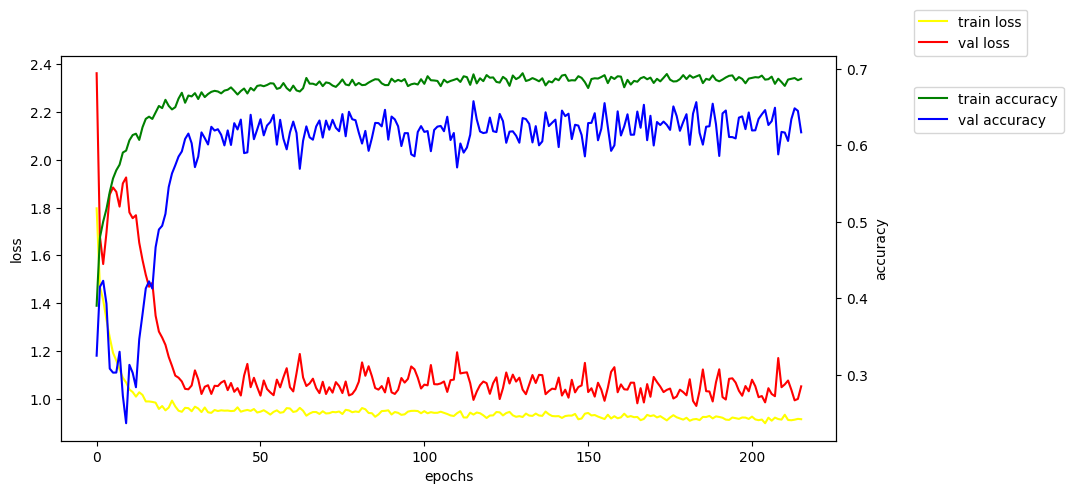

In [57]:
# hist.history.keys() # loss accuracy val_loss val_accuracy
fig, loss_ax = plt.subplots(figsize = (10,5))
loss_ax.plot(hist.history.get('loss'), color='yellow', label='train loss')
loss_ax.plot(hist.history.get('val_loss'), color='red', label='val loss')
loss_ax.legend(loc=(1.1,1))
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history.get('accuracy'), color='green', label='train accuracy')
acc_ax.plot(hist.history.get('val_accuracy'), color='blue', label='val accuracy')
acc_ax.legend(loc=(1.1,0.8))
acc_ax.set_ylabel('accuracy')
plt.show()

# 모델 평가하기

In [97]:
loss, accuracy = model.evaluate(X_va,y_va)

286/286 [==============================] - 1s 3ms/step - loss: 0.9952 - accuracy: 0.6579


In [98]:
y_hat = model.predict(X_va)

286/286 [==============================] - 0s 1ms/step


In [107]:
f1 = f1_score(y_va.argmax(axis=1),y_hat.argmax(axis=1),average='weighted')
precision = precision_score(y_va.argmax(axis=1),y_hat.argmax(axis=1),average='weighted')
recall = recall_score(y_va.argmax(axis=1),y_hat.argmax(axis=1),average='weighted')
print('loss',loss)
print('precision',precision)
print('recall',recall)
print('f1',f1)

loss 0.9951736927032471
precision 0.6695063610337035
recall 0.6578630136986301
f1 0.6609929690002994


# 모델 사용하기

In [111]:
# 8) 샘플 예측 (2025-06-22 강남구)
sample = pd.DataFrame([{
    "gu_le":        le_gu.transform(["강남구"])[0],
    "month":        6,
    "weekday":      6,
    "is_weekend":   0,
    "평균기온(°C)":  28.2,
    "일강수량(mm)":  0.0,
    "평균 풍속(m/s)": 4.2,
    "평균 상대습도(%)":100,
    '총생활인구수' : 755980.448275,
    '자전거전용도로km' : 114.0 
}])
X_samp = scaler.transform(sample[FEATURES].values.reshape(1,-1))

# DNN 예측
bin_idx_dnn = model.predict(X_samp).argmax(axis=1)[0]
print("▶ DNN 예측 구간:", le_y.inverse_transform([bin_idx_dnn])[0])

1/1 [==============================] - 0s 15ms/step
▶ DNN 예측 구간: 1500–2999


In [112]:
model.save('model_1/DNN_model_1.h5')